###Libraries

In [ ]:
!pip install pyspark
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=8e74be832d91080bc25d44e82ba662602e617bb0a5a77e3418f56cf4ac7abe5b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Importing Libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import when
from pyspark.sql.types import StringType, FloatType
from pyspark.sql.functions import col

spark = SparkSession.builder.getOrCreate()

### Dataset Preprocessing

In [ ]:
# Membaca dataset yang sudah disiapkan
SleepHealth_df = spark.read.option("inferSchema", "true").csv("SleepHealthDataset.csv", header=True)

SleepHealth_df.show(10)

+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|Person ID|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|        1|  Male| 27|   Software Engineer|           6.1|               6|                     42|           6|  Overweight|        126/83|        77|       4200|          None|
|        2|  Male| 28|              Doctor|           6.2|               6|                     60|           8|      Normal|        125/80|        75|      10000|          None|
|        3|  Male| 28|              Doctor|           6.2|               6|                     60|      

In [ ]:
SleepHealth_df = SleepHealth_df.select("Gender" , "Age", "Quality of Sleep", "Physical Activity Level", "Stress Level", "BMI Category", "Daily Steps", "Sleep Disorder")

SleepHealth_df.show(10)

+------+---+----------------+-----------------------+------------+------------+-----------+--------------+
|Gender|Age|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Daily Steps|Sleep Disorder|
+------+---+----------------+-----------------------+------------+------------+-----------+--------------+
|     1| 27|               6|                     42|           6|           1|       4200|             0|
|     1| 28|               6|                     60|           8|           0|      10000|             0|
|     1| 28|               6|                     60|           8|           0|      10000|             0|
|     1| 28|               4|                     30|           8|           2|       3000|             2|
|     1| 28|               4|                     30|           8|           2|       3000|             2|
|     1| 28|               4|                     30|           8|           2|       3000|             1|
|     1| 29|               6|        

In [ ]:
SleepHealth_df = SleepHealth_df.withColumn("Gender", when(SleepHealth_df["Gender"] == "Female", 0)
                                            .when(SleepHealth_df["Gender"] == "Male", 1))

In [ ]:
SleepHealth_df = SleepHealth_df.withColumn("BMI Category", when(SleepHealth_df["BMI Category"] == "Normal", 0)
                                            .when(SleepHealth_df["BMI Category"] == "Normal Weight", 0)
                                            .when(SleepHealth_df["BMI Category"] == "Overweight", 1)
                                            .when(SleepHealth_df["BMI Category"] == "Obese", 2))

In [ ]:
SleepHealth_df = SleepHealth_df.withColumn("Sleep Disorder", when(SleepHealth_df["Sleep Disorder"] == "None", 0)
                                            .when(SleepHealth_df["Sleep Disorder"] == "Insomnia", 1)
                                            .when(SleepHealth_df["Sleep Disorder"] == "Sleep Apnea", 2))

In [ ]:
SleepHealth_df.show(10)

+------+---+----------------+-----------------------+------------+------------+-----------+--------------+
|Gender|Age|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Daily Steps|Sleep Disorder|
+------+---+----------------+-----------------------+------------+------------+-----------+--------------+
|     1| 27|               6|                     42|           6|           1|       4200|             0|
|     1| 28|               6|                     60|           8|           0|      10000|             0|
|     1| 28|               6|                     60|           8|           0|      10000|             0|
|     1| 28|               4|                     30|           8|           2|       3000|             2|
|     1| 28|               4|                     30|           8|           2|       3000|             2|
|     1| 28|               4|                     30|           8|           2|       3000|             1|
|     1| 29|               6|        

In [ ]:
SleepHealth_df.printSchema()

root
 |-- Gender: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Quality of Sleep: integer (nullable = true)
 |-- Physical Activity Level: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- BMI Category: integer (nullable = true)
 |-- Daily Steps: integer (nullable = true)
 |-- Sleep Disorder: integer (nullable = true)



In [ ]:
SleepHealth_df = SleepHealth_df.na.drop()

In [ ]:
cols = list(SleepHealth_df.columns)
cols.remove("Sleep Disorder")

assembler = VectorAssembler(inputCols=cols, outputCol="features")
SleepHealth_df = assembler.transform(SleepHealth_df)

# Split data (80% for training, 20% for testing)
(trainingData, testingData) = SleepHealth_df.randomSplit([0.8, 0.2])

trainingData.show(10)
testingData.show(10)

+------+---+----------------+-----------------------+------------+------------+-----------+--------------+--------------------+
|Gender|Age|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Daily Steps|Sleep Disorder|            features|
+------+---+----------------+-----------------------+------------+------------+-----------+--------------+--------------------+
|     0| 29|               5|                     40|           7|           0|       4000|             1|[0.0,29.0,5.0,40....|
|     0| 30|               5|                     35|           7|           0|       4100|             1|[0.0,30.0,5.0,35....|
|     0| 30|               5|                     35|           7|           0|       4100|             2|[0.0,30.0,5.0,35....|
|     0| 31|               8|                     75|           4|           0|       6800|             0|[0.0,31.0,8.0,75....|
|     0| 33|               6|                     50|           6|           1|       5500|             

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(trainingData)
trainingData = scaler_model.transform(trainingData)
testingData = scaler_model.transform(testingData)

### Data Visualization

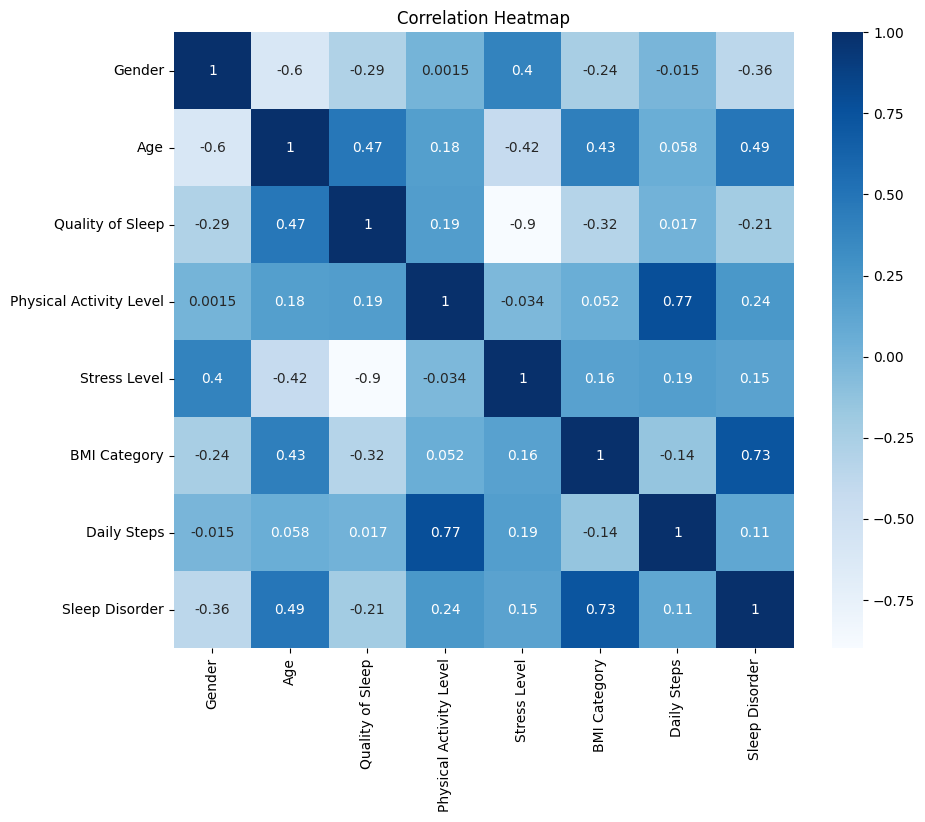

In [ ]:
SleepHealth_pd = SleepHealth_df.select("Gender" , "Age", "Quality of Sleep", "Physical Activity Level", "Stress Level", "BMI Category", "Daily Steps", "Sleep Disorder")

SleepHealth_pd = SleepHealth_pd.toPandas()
correlation_matrix = SleepHealth_pd.corr()

SleepHealth_temppd = SleepHealth_pd[SleepHealth_pd['Sleep Disorder'] != 0]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues")  # Use a valid color map name
plt.title("Correlation Heatmap")  # plt.title instead of sns.title
plt.show()  # Ensure to call plt.show() with parentheses

<ipython-input-572-43e362272ee1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SleepHealth_temppd['Gender_mapped'] = SleepHealth_temppd['Gender'].replace(Gender_mapping)


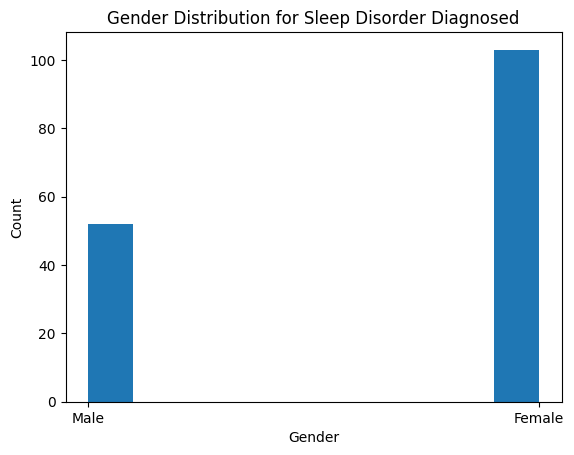

In [ ]:
Gender_mapping = {
    0: 'Female',
    1: 'Male',
}

SleepHealth_temppd['Gender_mapped'] = SleepHealth_temppd['Gender'].replace(Gender_mapping)

plt.hist(SleepHealth_temppd['Gender_mapped'], bins=10)
plt.title('Gender Distribution for Sleep Disorder Diagnosed')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

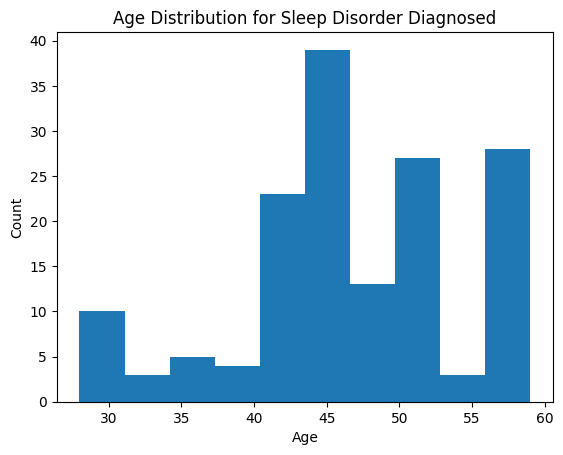

In [ ]:
plt.hist(SleepHealth_temppd['Age'], bins=10)
plt.title('Age Distribution for Sleep Disorder Diagnosed')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

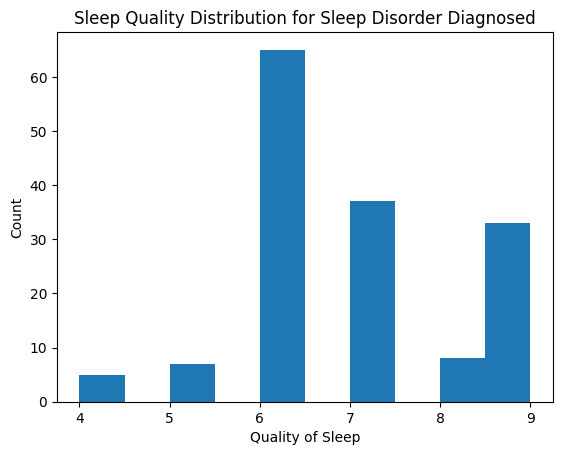

In [ ]:
plt.hist(SleepHealth_temppd['Quality of Sleep'], bins=10)
plt.title('Sleep Quality Distribution for Sleep Disorder Diagnosed')
plt.xlabel('Quality of Sleep')
plt.ylabel('Count')
plt.show()

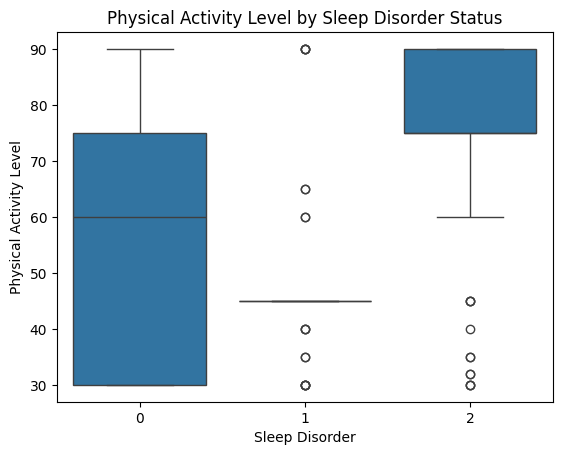

In [ ]:
sns.boxplot(x=SleepHealth_pd['Sleep Disorder'], y=SleepHealth_pd['Physical Activity Level'])
plt.xlabel('Sleep Disorder')
plt.ylabel('Physical Activity Level')
plt.title('Physical Activity Level by Sleep Disorder Status')
plt.show()

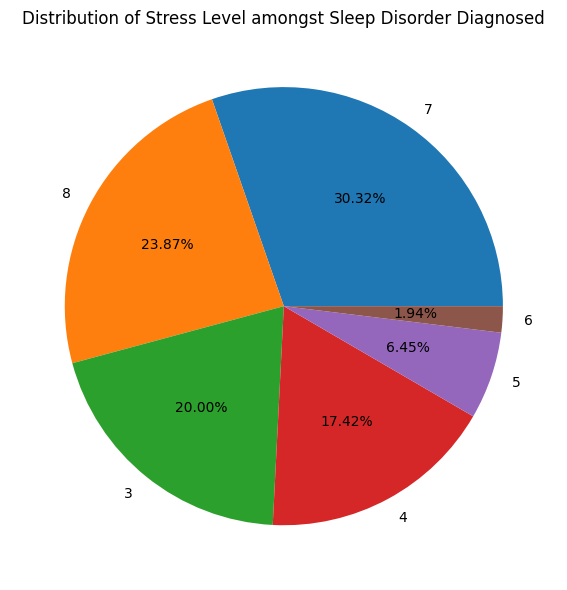

In [ ]:
stressprediction = SleepHealth_temppd['Stress Level'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(stressprediction.values, labels=stressprediction.index, autopct="%.2f%%")
plt.title('Distribution of Stress Level amongst Sleep Disorder Diagnosed')
plt.tight_layout()
plt.show()

<ipython-input-568-65c29466c26d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SleepHealth_temppd['BMICategory_mapped'] = SleepHealth_temppd['BMI Category'].replace(BMICategory_mapping)


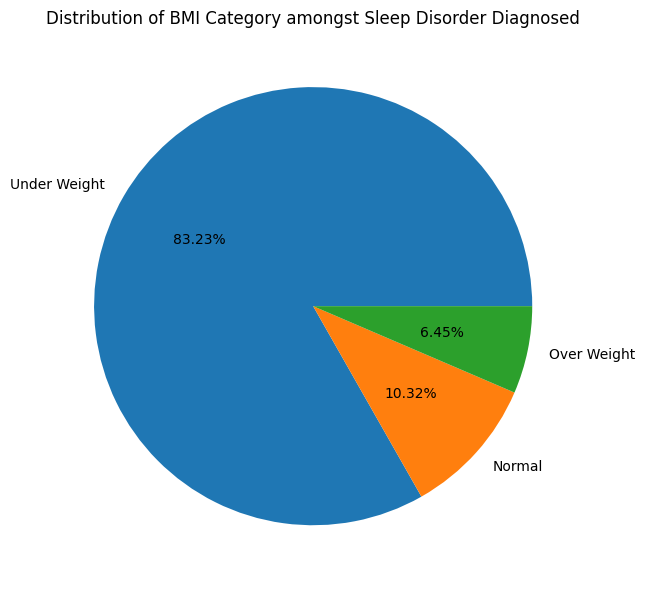

In [ ]:
BMICategory_mapping = {
    0: 'Normal',
    1: 'Under Weight',
    2: 'Over Weight',
}

SleepHealth_temppd['BMICategory_mapped'] = SleepHealth_temppd['BMI Category'].replace(BMICategory_mapping)
stressprediction = SleepHealth_temppd['BMICategory_mapped'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(stressprediction.values, labels=stressprediction.index, autopct="%.2f%%")
plt.title('Distribution of BMI Category amongst Sleep Disorder Diagnosed')
plt.tight_layout()
plt.show()

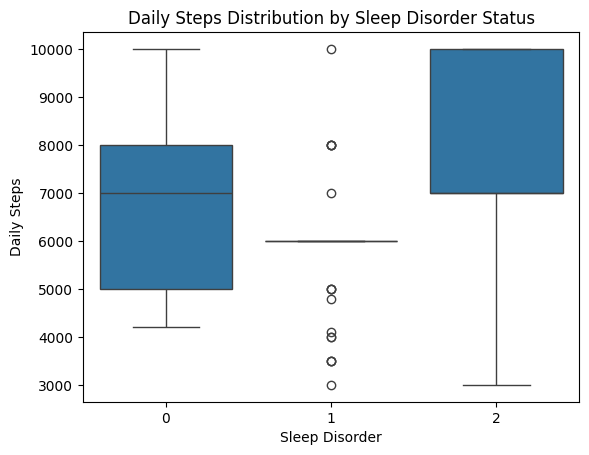

In [ ]:
sns.boxplot(x=SleepHealth_pd['Sleep Disorder'], y=SleepHealth_pd['Daily Steps'])
plt.xlabel('Sleep Disorder')
plt.ylabel('Daily Steps')
plt.title('Daily Steps Distribution by Sleep Disorder Status')
plt.show()

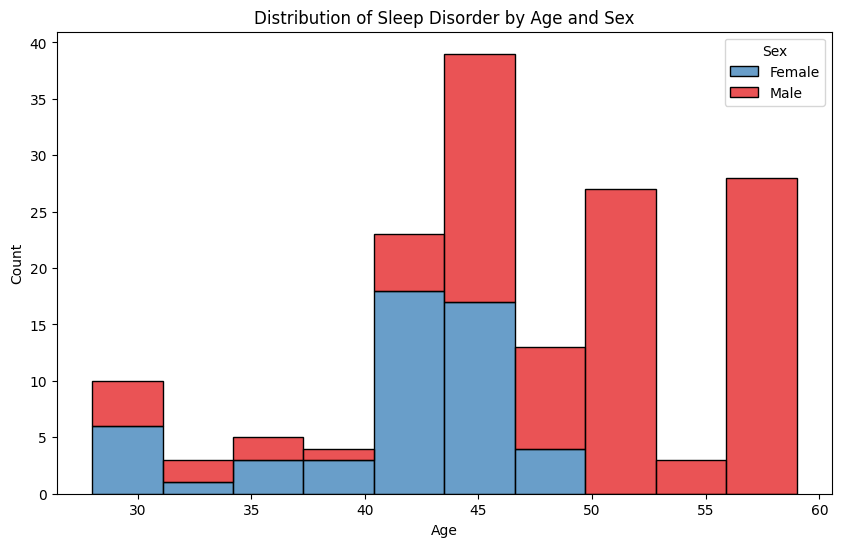

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=SleepHealth_temppd, x='Age', hue='Gender', multiple='stack', bins=10, palette='Set1', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Sleep Disorder by Age and Sex')
plt.legend(title='Sex', labels=['Female', 'Male'])
plt.show()

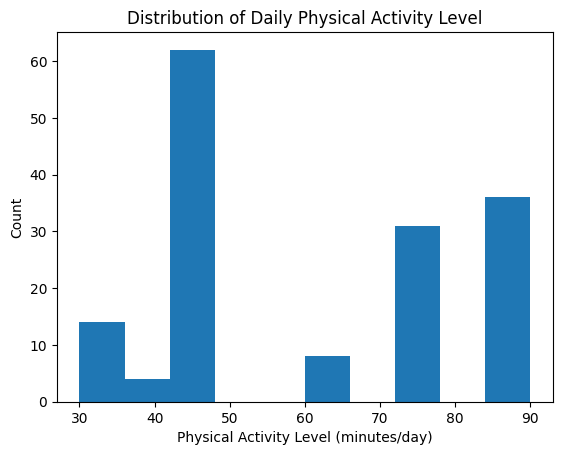

In [ ]:
plt.hist(SleepHealth_temppd['Physical Activity Level'], bins=10)
plt.title('Distribution of Daily Physical Activity Level')
plt.xlabel('Physical Activity Level (minutes/day)')
plt.ylabel('Count')
plt.show()

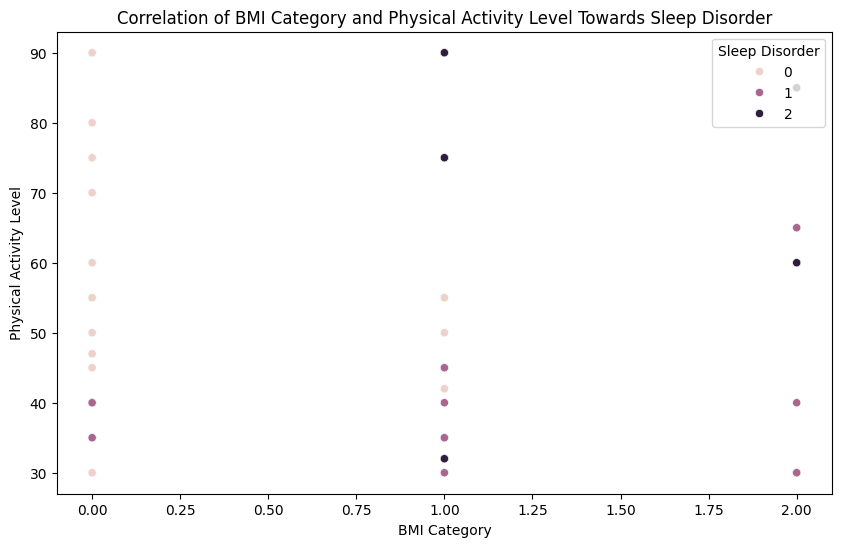

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='BMI Category', y='Physical Activity Level', hue='Sleep Disorder', data=SleepHealth_pd)
plt.title('Correlation of BMI Category and Physical Activity Level Towards Sleep Disorder')
plt.xlabel('BMI Category')
plt.ylabel('Physical Activity Level')
plt.show()

### Modeling

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='Sleep Disorder')
rf_model = rf.fit(trainingData)
rf_model = rf.fit(trainingData)

#Gradient Boosting
rf_predictions = rf_model.transform(testingData)
#dt_predictions.show()

#Accuracy
accuracy = evaluator.evaluate(rf_predictions)
print("Random Forest Accuracy: {:.2f}%".format(accuracy * 100))

Random Forest Accuracy: 92.21%
